1. Run BOSTON
2. Notice that the mini-batch size is set to 1. Experiment with different mini-batch sizes. What do you observe? Can you account for your observation?
2. Run a series of experiments to find the best model. (Hint: look back at the previous labs.)
3. Retrain the best model on all the training data and evaluate on the test data

In [1]:
import tensorflow as tf
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2022-05-19 13:58:26.695328: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


True

2022-05-19 13:58:26.742340: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-19 13:58:26.766500: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-19 13:58:26.767448: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-19 13:58:27.322095: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-19 13:58:27.322514: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from S

In [3]:
# BOSTON

from tensorflow.keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

mean = train_data.mean(axis = 0)
train_data -= mean # shift
std = train_data.std(axis = 0)
train_data /= std # rescale

test_data -= mean
test_data /= std

from tensorflow.keras import models
from tensorflow.keras import layers

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, 
                           activation = 'relu', 
                           input_shape = (train_data.shape[1], )))
    model.add(layers.Dense(16, activation = 'relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer = 'rmsprop', loss = 'mse', metrics = ['mae'])
    
    return model

In [4]:
import tensorflow as tf

class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        c = ['\b|', '\b/', '\b-', '\b\\'] 
        print(c[epoch % 4], end='')
    def on_epoch_end(self, epoch, logs=None):
        print('\b', end='')

In [5]:
import numpy as np, tensorflow as tf
K = 4
num_val_samples = len(train_data) // K
num_epochs = 8
all_mae_histories = []

import time
T1 = time.time()

for i in range(K):
    print('processing fold', i)
    
    # Prepare the validation data: data from partition i
    a, b = i * num_val_samples, (i + 1) * num_val_samples
    val_data = train_data[a : b]
    val_targets = train_targets[a : b]
    
    # Prepare the training data: data from all other partitions
    partial_train_data = np.concatenate([train_data[:a], train_data[b:]], axis=0)
    partial_train_targets = np.concatenate([train_targets[:a], train_targets[b:]], axis=0)

    # Build the Keras model (already compiled)
    model = build_model()
    
    # Train the model (in silent mode, verbose=0)
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0, 
                        callbacks=[CustomCallback()])

    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

T2 = time.time()
print('程序运行时间:%s毫秒' % ((T2 - T1)*1000))

processing fold 0


2022-05-19 13:58:49.055955: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-19 13:58:49.056507: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-19 13:58:49.056925: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-19 13:58:49.058077: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-19 13:58:49.058766: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from S

processing fold 1
processing fold 2
processing fold 3
程序运行时间:17809.396505355835毫秒


In [ ]:
888206

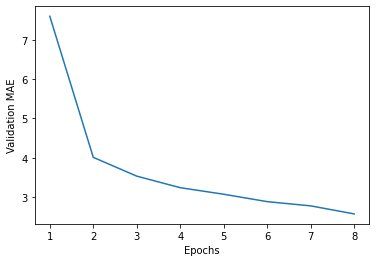

In [6]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories])for i in range(num_epochs)]

import matplotlib.pyplot as plt
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

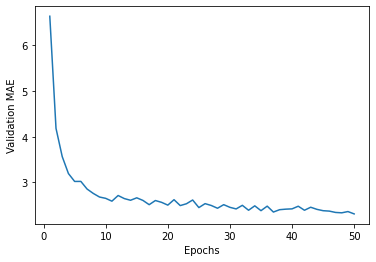

In [5]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories])for i in range(num_epochs)]

import matplotlib.pyplot as plt
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [12]:
def smooth_curve(points, factor = 0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points: # an empty list is 'False'
            previous = smoothed_points[-1] # the last appended point
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

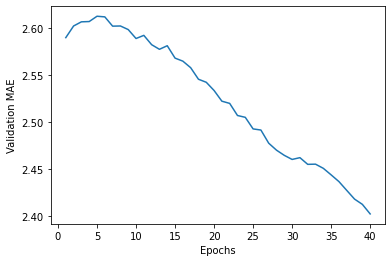

In [13]:
smooth_mae_history = smooth_curve(average_mae_history[10:])
plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [10]:
history.history['val_mae']


[9.8804292678833,
 5.763534069061279,
 4.833794116973877,
 4.161961555480957,
 3.8073017597198486,
 3.9239284992218018,
 3.5349812507629395,
 3.3018085956573486,
 3.2016096115112305,
 3.1670937538146973,
 2.9794347286224365,
 3.1879847049713135,
 3.0438692569732666,
 2.751929521560669,
 3.080322504043579,
 2.92655086517334,
 2.616530656814575,
 2.7354509830474854,
 2.8012874126434326,
 2.7034003734588623,
 2.7648000717163086,
 2.6985936164855957,
 2.6779518127441406,
 2.647447109222412,
 2.602304220199585,
 2.626833200454712,
 2.612966299057007,
 2.5461935997009277,
 2.6315126419067383,
 2.586205005645752,
 2.476073980331421,
 2.6163272857666016,
 2.5880725383758545,
 2.518186092376709,
 2.5631542205810547,
 2.6228697299957275,
 2.382594585418701,
 2.473604917526245,
 2.4959890842437744,
 2.4934463500976562,
 2.4715750217437744,
 2.4353854656219482,
 2.448845386505127,
 2.3830692768096924,
 2.3892085552215576,
 2.438042402267456,
 2.4787917137145996,
 2.407987594604492,
 2.378395080566